In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images.shape

(60000, 28, 28, 1)

In [4]:
train_images[56782, :10, :10]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  1.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 74.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [  0.],
        [ 77.],
        [207.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [  0.],
        [124.],
        [176.],
        [192.],
        [180.]],

       [[  0.],
        [  0.],
        [  0.],
        [  1.],
        [  0.],
        [ 88.],
        [207.],
        [184.],
        [183.],
        [182.]],

       [[  0.],
        [  0

In [5]:
train_images = (train_images - 127.5) / 127.5

train_images[56782, :10, :10]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

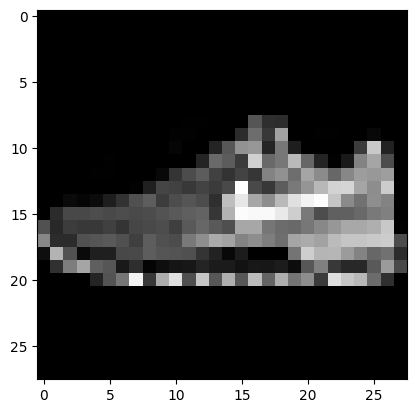

In [14]:
plt.imshow(train_images[2567].squeeze(), cmap = 'gray')

In [15]:
buffer_size = 60000
batch_size = 128

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [19]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim = 100))
    model.add(layers.ReLU())
    model.add(layers.Dense(128))
    model.add(layers.ReLU())
    model.add(layers.Dense(256))
    model.add(layers.ReLU())
    model.add(layers.Dense(784, activation = 'tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

In [20]:
generator = generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 re_lu_3 (ReLU)              (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_4 (ReLU)              (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_5 (ReLU)              (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 784)              

In [21]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 28, 28, 1])

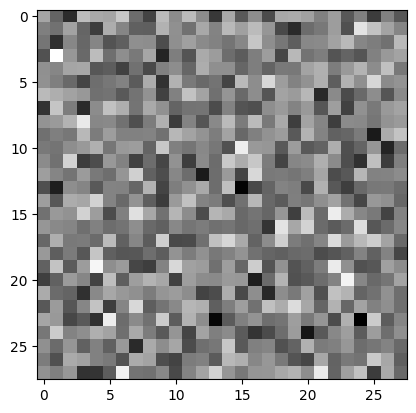

In [22]:
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

In [23]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))
    return model

In [24]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [25]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.48755243]], shape=(1, 1), dtype=float32)


In [26]:
bce = tf.keras.losses.BinaryCrossentropy()

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [28]:
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

The discriminator and the generator optimizers are different since two networks would be trained separately.

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [31]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [32]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [33]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [34]:
def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []

    real_score_list =[]
    fake_score_list =[]
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches...')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches

        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%'  %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 469 batches...
Losses after epoch     1: generator 2.475, discriminator 0.434, real_score 89.40%, fake_score 14.09%


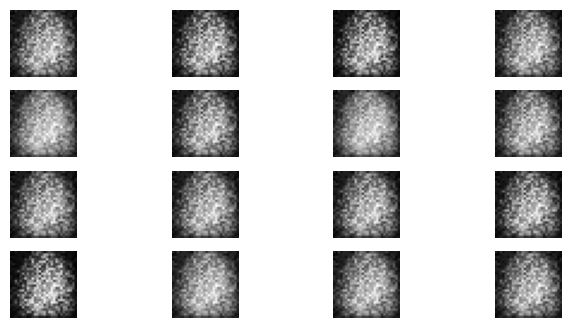

  2%|▏         | 1/50 [00:08<07:20,  9.00s/it]

Time for epoch 1 is 8.997267723083496 sec
Training started with  epoch 2 with 469 batches...
Losses after epoch     2: generator 5.149, discriminator 0.678, real_score 92.12%, fake_score 6.72%


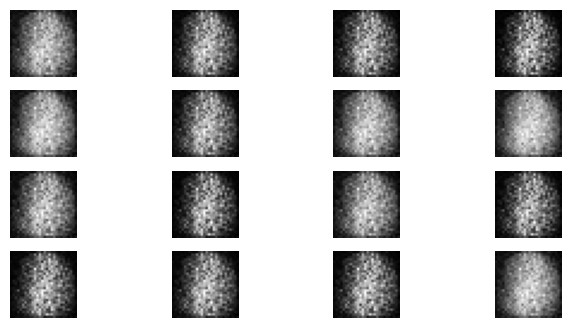

  4%|▍         | 2/50 [00:12<04:28,  5.60s/it]

Time for epoch 2 is 3.222712278366089 sec
Training started with  epoch 3 with 469 batches...
Losses after epoch     3: generator 4.452, discriminator 0.327, real_score 86.78%, fake_score 6.51%


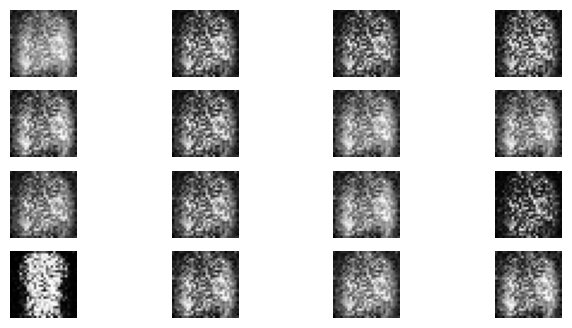

  6%|▌         | 3/50 [00:14<03:19,  4.25s/it]

Time for epoch 3 is 2.633533239364624 sec
Training started with  epoch 4 with 469 batches...
Losses after epoch     4: generator 1.759, discriminator 0.557, real_score 82.81%, fake_score 21.70%


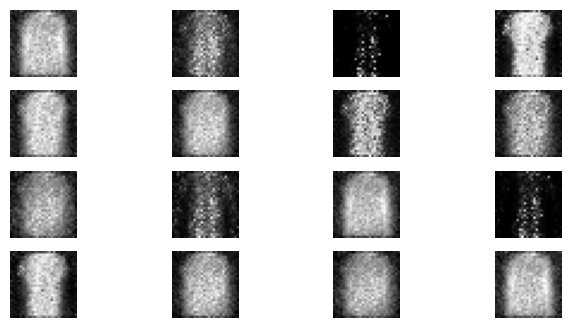

  8%|▊         | 4/50 [00:17<02:45,  3.61s/it]

Time for epoch 4 is 2.620818853378296 sec
Training started with  epoch 5 with 469 batches...
Losses after epoch     5: generator 2.194, discriminator 0.447, real_score 88.96%, fake_score 21.75%


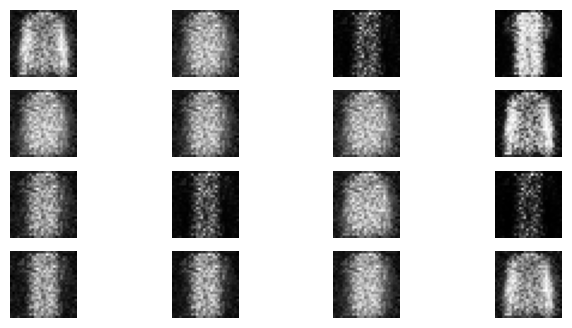

 10%|█         | 5/50 [00:20<02:29,  3.33s/it]

Time for epoch 5 is 2.8373353481292725 sec
Training started with  epoch 6 with 469 batches...
Losses after epoch     6: generator 3.373, discriminator 0.580, real_score 81.60%, fake_score 9.25%


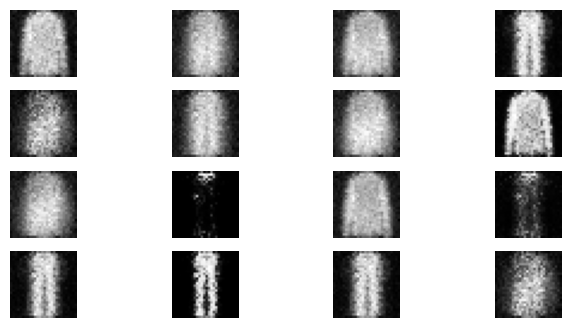

 12%|█▏        | 6/50 [00:23<02:20,  3.20s/it]

Time for epoch 6 is 2.931971311569214 sec
Training started with  epoch 7 with 469 batches...
Losses after epoch     7: generator 3.217, discriminator 0.218, real_score 92.60%, fake_score 7.76%


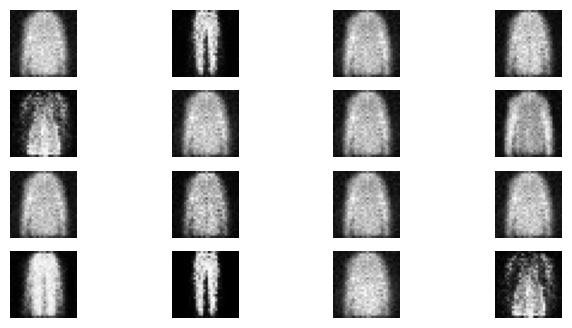

 14%|█▍        | 7/50 [00:26<02:16,  3.17s/it]

Time for epoch 7 is 3.0958900451660156 sec
Training started with  epoch 8 with 469 batches...
Losses after epoch     8: generator 2.622, discriminator 0.539, real_score 85.26%, fake_score 17.07%


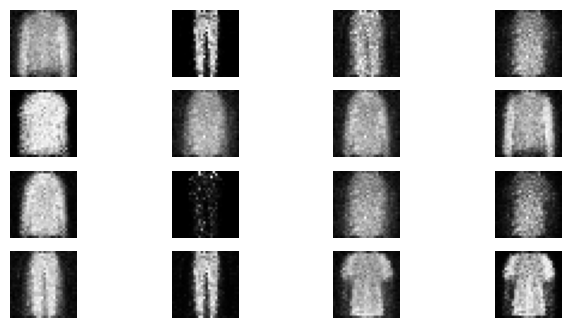

 16%|█▌        | 8/50 [00:28<02:05,  2.98s/it]

Time for epoch 8 is 2.5789906978607178 sec
Training started with  epoch 9 with 469 batches...
Losses after epoch     9: generator 2.345, discriminator 0.423, real_score 90.57%, fake_score 17.47%


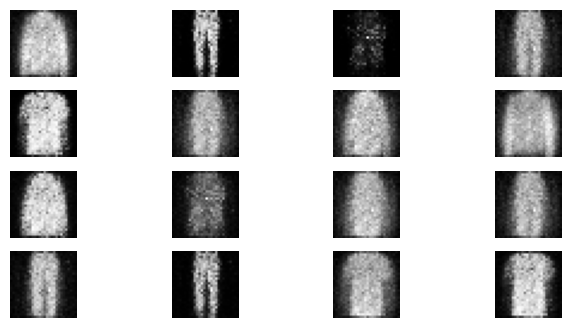

 18%|█▊        | 9/50 [00:31<02:00,  2.94s/it]

Time for epoch 9 is 2.8515238761901855 sec
Training started with  epoch 10 with 469 batches...
Losses after epoch    10: generator 2.580, discriminator 0.392, real_score 88.62%, fake_score 13.71%


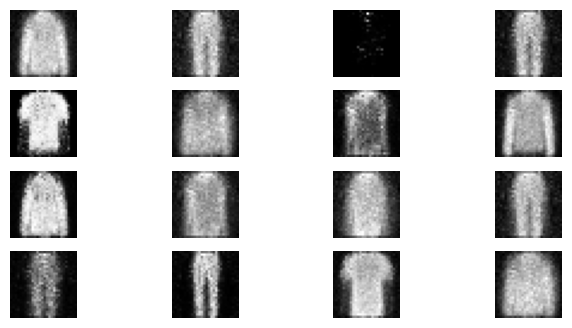

 20%|██        | 10/50 [00:34<01:55,  2.88s/it]

Time for epoch 10 is 2.751957893371582 sec
Training started with  epoch 11 with 469 batches...
Losses after epoch    11: generator 2.647, discriminator 0.526, real_score 79.51%, fake_score 12.72%


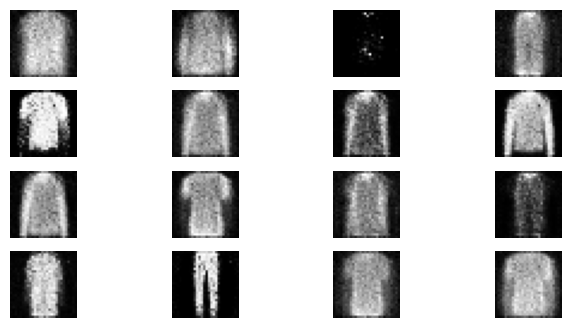

 22%|██▏       | 11/50 [00:37<01:56,  2.99s/it]

Time for epoch 11 is 3.238630533218384 sec
Training started with  epoch 12 with 469 batches...
Losses after epoch    12: generator 2.773, discriminator 0.396, real_score 85.95%, fake_score 12.95%


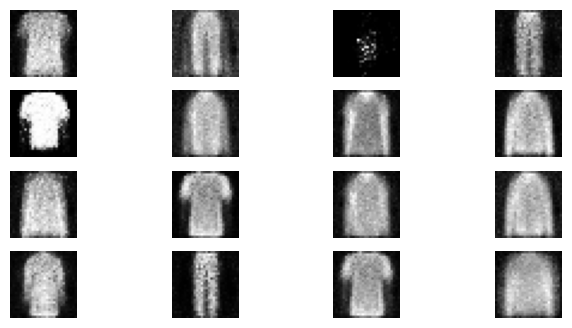

 24%|██▍       | 12/50 [00:40<01:50,  2.90s/it]

Time for epoch 12 is 2.699970245361328 sec
Training started with  epoch 13 with 469 batches...
Losses after epoch    13: generator 2.730, discriminator 0.760, real_score 80.86%, fake_score 17.70%


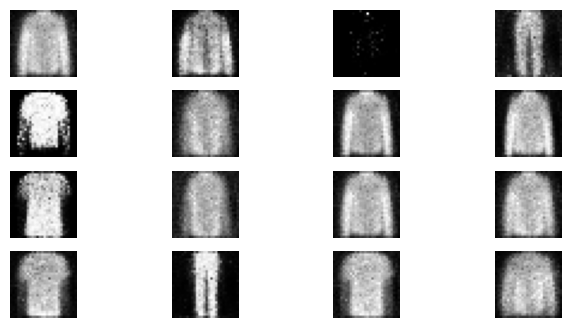

 26%|██▌       | 13/50 [00:43<01:47,  2.91s/it]

Time for epoch 13 is 2.8959834575653076 sec
Training started with  epoch 14 with 469 batches...
Losses after epoch    14: generator 3.106, discriminator 0.529, real_score 83.69%, fake_score 12.81%


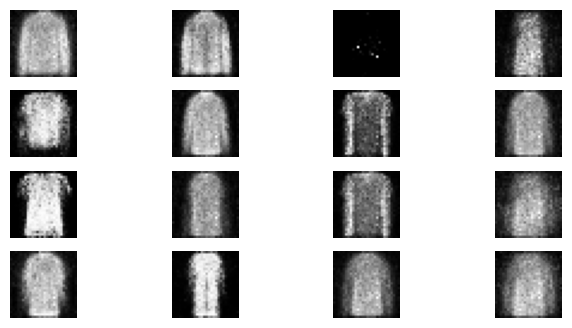

 28%|██▊       | 14/50 [00:46<01:41,  2.81s/it]

Time for epoch 14 is 2.577206611633301 sec
Training started with  epoch 15 with 469 batches...
Losses after epoch    15: generator 2.529, discriminator 0.461, real_score 82.80%, fake_score 14.80%


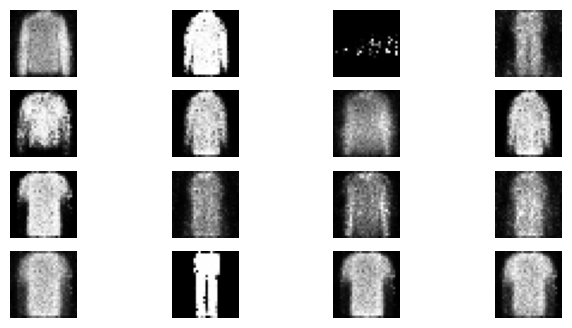

 30%|███       | 15/50 [00:48<01:40,  2.87s/it]

Time for epoch 15 is 2.9865355491638184 sec
Training started with  epoch 16 with 469 batches...
Losses after epoch    16: generator 2.718, discriminator 0.488, real_score 82.57%, fake_score 12.71%


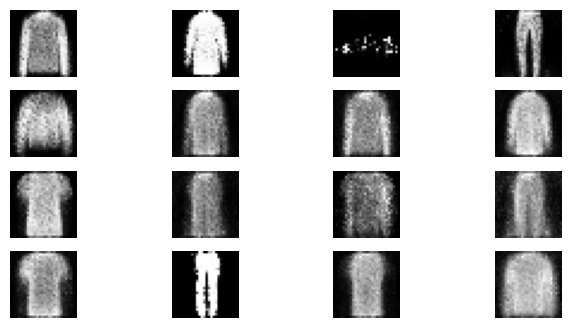

 32%|███▏      | 16/50 [00:52<01:39,  2.94s/it]

Time for epoch 16 is 3.099879264831543 sec
Training started with  epoch 17 with 469 batches...
Losses after epoch    17: generator 1.854, discriminator 0.759, real_score 73.09%, fake_score 20.10%


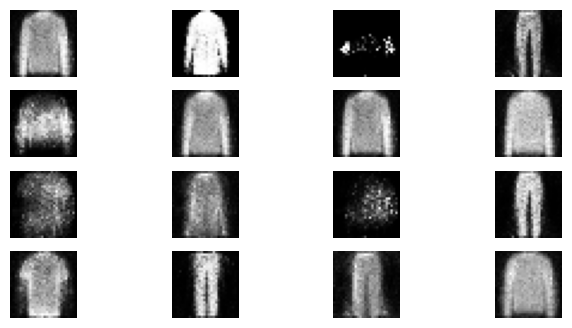

 34%|███▍      | 17/50 [00:54<01:34,  2.87s/it]

Time for epoch 17 is 2.701997756958008 sec
Training started with  epoch 18 with 469 batches...
Losses after epoch    18: generator 2.087, discriminator 0.739, real_score 76.83%, fake_score 20.59%


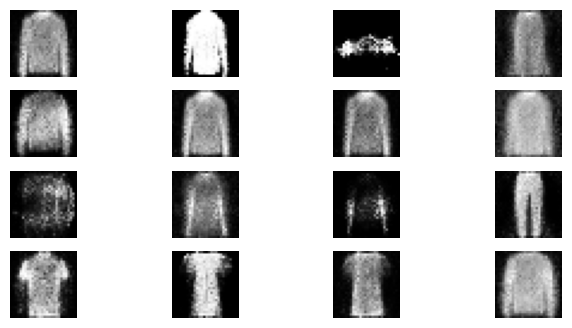

 36%|███▌      | 18/50 [00:57<01:32,  2.89s/it]

Time for epoch 18 is 2.935720443725586 sec
Training started with  epoch 19 with 469 batches...
Losses after epoch    19: generator 2.604, discriminator 0.523, real_score 89.66%, fake_score 19.16%


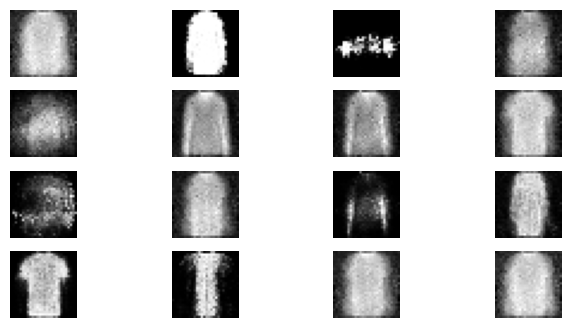

 38%|███▊      | 19/50 [01:00<01:27,  2.84s/it]

Time for epoch 19 is 2.711315155029297 sec
Training started with  epoch 20 with 469 batches...
Losses after epoch    20: generator 1.855, discriminator 0.778, real_score 75.56%, fake_score 22.60%


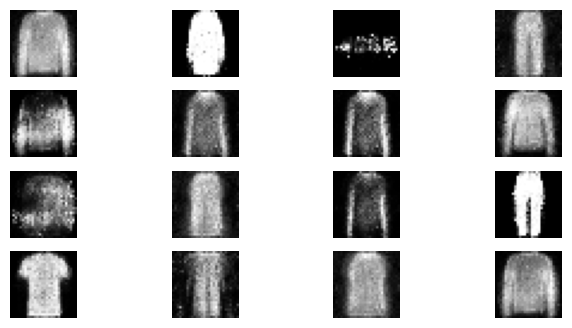

 40%|████      | 20/50 [01:03<01:29,  3.00s/it]

Time for epoch 20 is 3.3727550506591797 sec
Training started with  epoch 21 with 469 batches...
Losses after epoch    21: generator 2.744, discriminator 0.714, real_score 77.63%, fake_score 16.35%


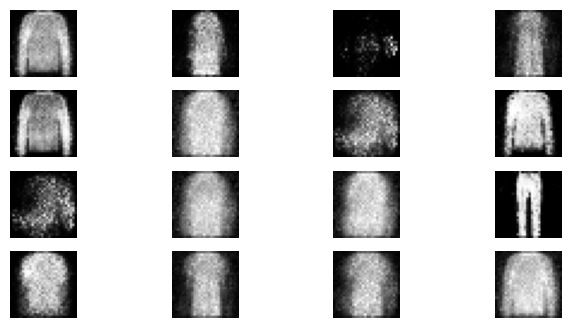

 42%|████▏     | 21/50 [01:06<01:24,  2.91s/it]

Time for epoch 21 is 2.7137489318847656 sec
Training started with  epoch 22 with 469 batches...
Losses after epoch    22: generator 1.600, discriminator 0.923, real_score 68.46%, fake_score 26.72%


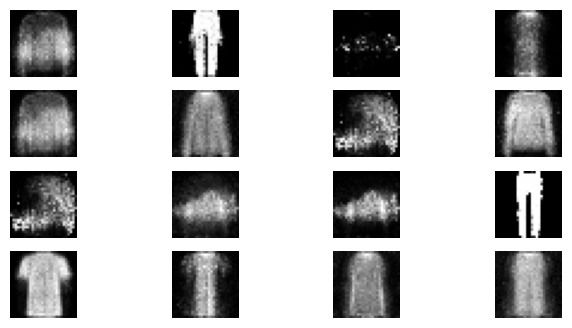

 44%|████▍     | 22/50 [01:09<01:21,  2.91s/it]

Time for epoch 22 is 2.9115936756134033 sec
Training started with  epoch 23 with 469 batches...
Losses after epoch    23: generator 2.355, discriminator 0.637, real_score 81.20%, fake_score 18.46%


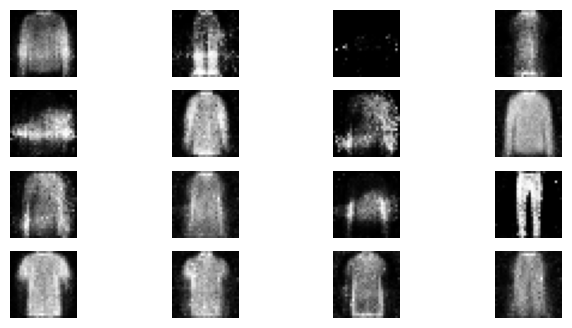

 46%|████▌     | 23/50 [01:12<01:16,  2.83s/it]

Time for epoch 23 is 2.6378142833709717 sec
Training started with  epoch 24 with 469 batches...
Losses after epoch    24: generator 2.494, discriminator 0.429, real_score 88.77%, fake_score 15.65%


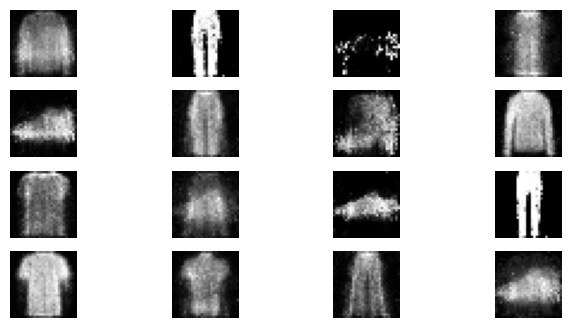

 48%|████▊     | 24/50 [01:14<01:14,  2.85s/it]

Time for epoch 24 is 2.8796980381011963 sec
Training started with  epoch 25 with 469 batches...
Losses after epoch    25: generator 2.382, discriminator 0.450, real_score 83.75%, fake_score 14.86%


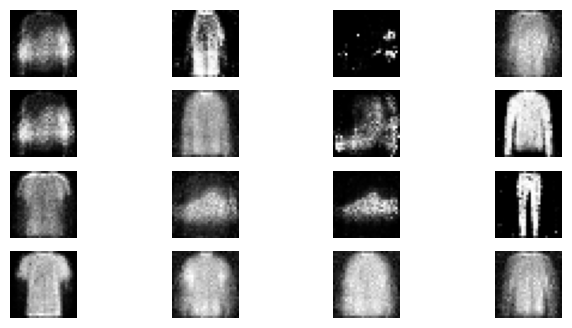

 50%|█████     | 25/50 [01:18<01:13,  2.93s/it]

Time for epoch 25 is 3.09702730178833 sec
Training started with  epoch 26 with 469 batches...
Losses after epoch    26: generator 1.968, discriminator 0.572, real_score 80.50%, fake_score 20.53%


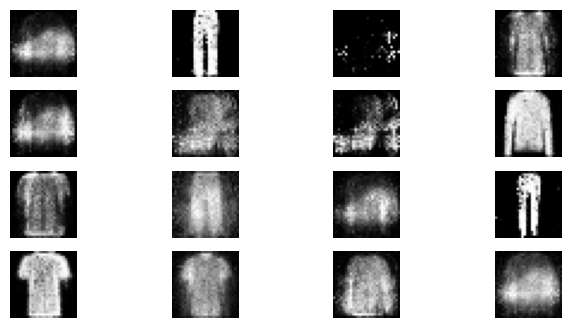

 52%|█████▏    | 26/50 [01:20<01:08,  2.85s/it]

Time for epoch 26 is 2.6711912155151367 sec
Training started with  epoch 27 with 469 batches...
Losses after epoch    27: generator 2.450, discriminator 0.661, real_score 78.03%, fake_score 16.31%


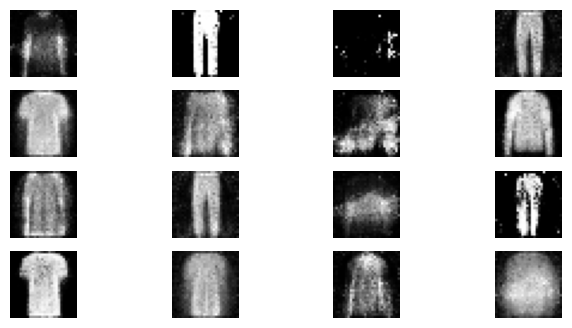

 54%|█████▍    | 27/50 [01:23<01:06,  2.87s/it]

Time for epoch 27 is 2.9230053424835205 sec
Training started with  epoch 28 with 469 batches...
Losses after epoch    28: generator 1.961, discriminator 0.925, real_score 81.49%, fake_score 27.22%


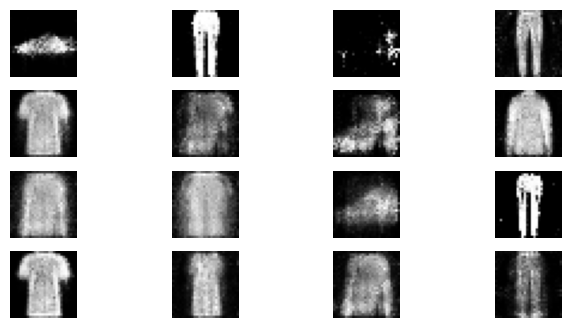

 56%|█████▌    | 28/50 [01:26<01:02,  2.82s/it]

Time for epoch 28 is 2.69911789894104 sec
Training started with  epoch 29 with 469 batches...
Losses after epoch    29: generator 2.562, discriminator 0.711, real_score 80.11%, fake_score 19.40%


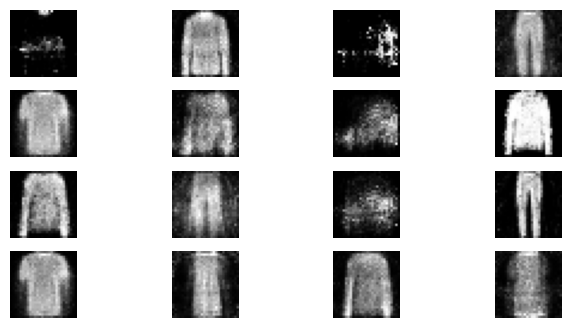

 58%|█████▊    | 29/50 [01:29<01:02,  2.96s/it]

Time for epoch 29 is 3.292865037918091 sec
Training started with  epoch 30 with 469 batches...
Losses after epoch    30: generator 2.540, discriminator 0.581, real_score 78.92%, fake_score 14.74%


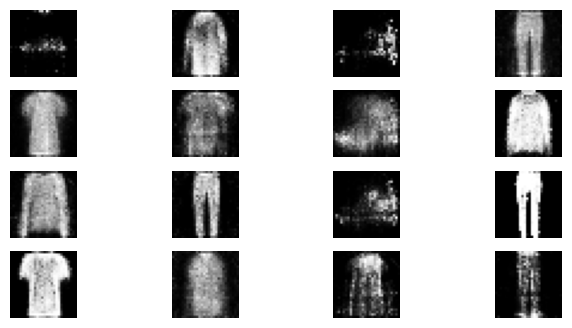

 60%|██████    | 30/50 [01:32<00:58,  2.91s/it]

Time for epoch 30 is 2.7671926021575928 sec
Training started with  epoch 31 with 469 batches...
Losses after epoch    31: generator 2.559, discriminator 0.686, real_score 79.01%, fake_score 19.49%


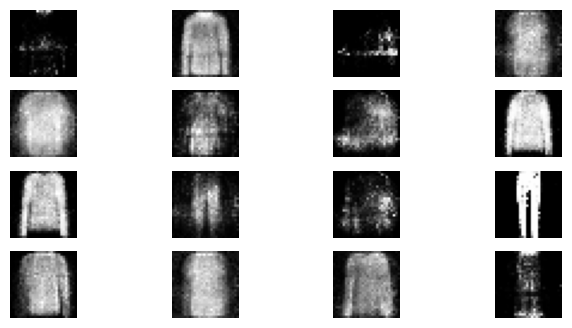

 62%|██████▏   | 31/50 [01:35<00:55,  2.90s/it]

Time for epoch 31 is 2.874946355819702 sec
Training started with  epoch 32 with 469 batches...
Losses after epoch    32: generator 1.691, discriminator 0.903, real_score 79.70%, fake_score 30.82%


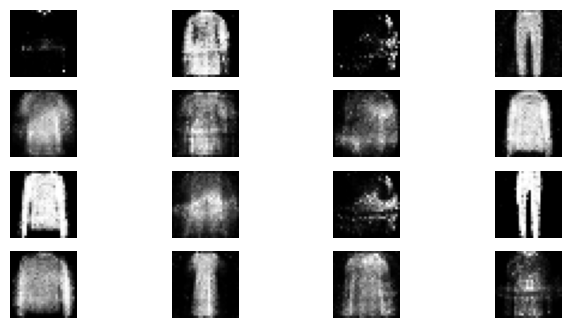

 64%|██████▍   | 32/50 [01:38<00:50,  2.83s/it]

Time for epoch 32 is 2.6765012741088867 sec
Training started with  epoch 33 with 469 batches...
Losses after epoch    33: generator 2.664, discriminator 0.727, real_score 78.58%, fake_score 19.60%


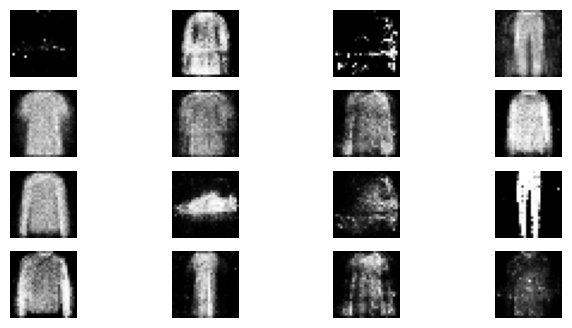

 66%|██████▌   | 33/50 [01:40<00:48,  2.87s/it]

Time for epoch 33 is 2.948029041290283 sec
Training started with  epoch 34 with 469 batches...
Losses after epoch    34: generator 2.080, discriminator 0.837, real_score 79.54%, fake_score 23.67%


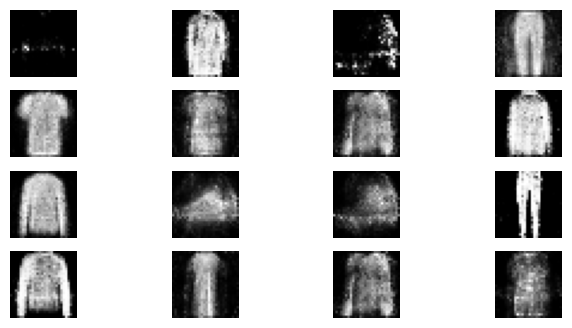

 68%|██████▊   | 34/50 [01:44<00:46,  2.92s/it]

Time for epoch 34 is 3.037914752960205 sec
Training started with  epoch 35 with 469 batches...
Losses after epoch    35: generator 2.605, discriminator 0.656, real_score 77.49%, fake_score 16.81%


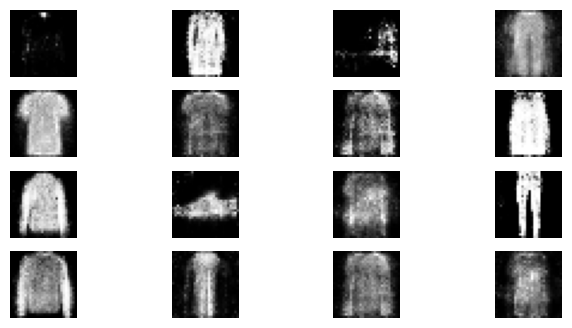

 70%|███████   | 35/50 [01:46<00:43,  2.93s/it]

Time for epoch 35 is 2.9463398456573486 sec
Training started with  epoch 36 with 469 batches...
Losses after epoch    36: generator 1.949, discriminator 0.684, real_score 77.66%, fake_score 20.50%


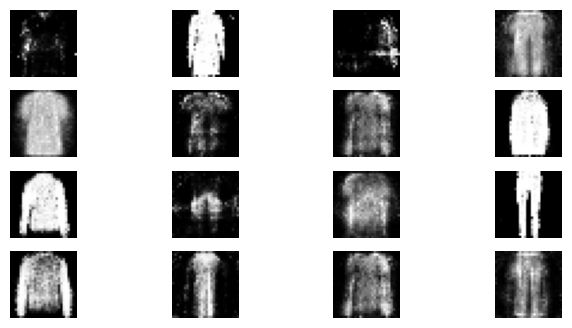

 72%|███████▏  | 36/50 [01:49<00:39,  2.85s/it]

Time for epoch 36 is 2.657850980758667 sec
Training started with  epoch 37 with 469 batches...
Losses after epoch    37: generator 1.540, discriminator 1.071, real_score 69.26%, fake_score 32.69%


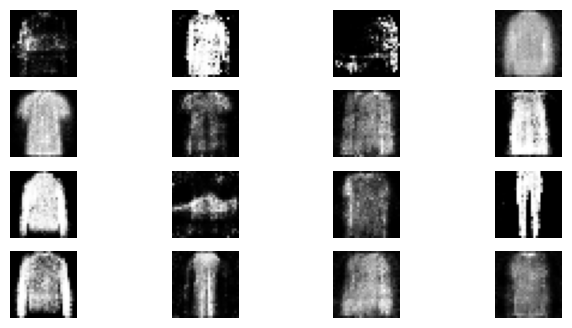

 74%|███████▍  | 37/50 [01:52<00:38,  3.00s/it]

Time for epoch 37 is 3.337240695953369 sec
Training started with  epoch 38 with 469 batches...
Losses after epoch    38: generator 1.927, discriminator 0.872, real_score 76.14%, fake_score 26.18%


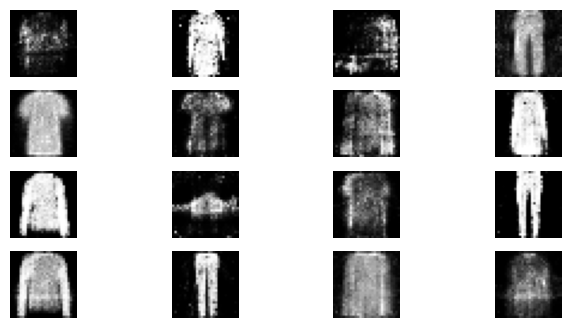

 76%|███████▌  | 38/50 [01:56<00:37,  3.09s/it]

Time for epoch 38 is 3.316176176071167 sec
Training started with  epoch 39 with 469 batches...
Losses after epoch    39: generator 1.971, discriminator 0.945, real_score 78.35%, fake_score 26.65%


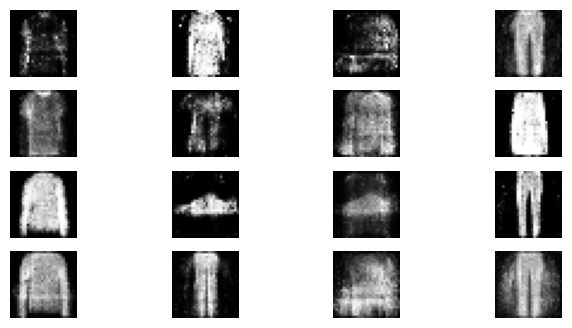

 78%|███████▊  | 39/50 [01:58<00:32,  2.98s/it]

Time for epoch 39 is 2.7087178230285645 sec
Training started with  epoch 40 with 469 batches...
Losses after epoch    40: generator 2.740, discriminator 0.503, real_score 81.67%, fake_score 14.12%


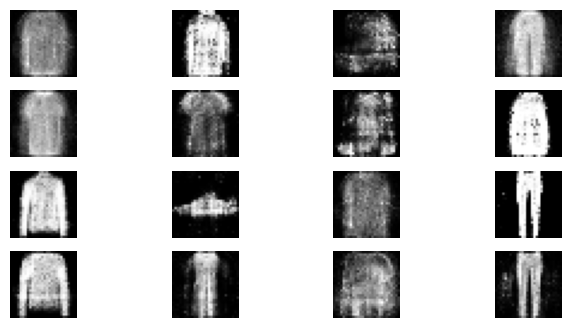

 80%|████████  | 40/50 [02:02<00:30,  3.03s/it]

Time for epoch 40 is 3.1354219913482666 sec
Training started with  epoch 41 with 469 batches...
Losses after epoch    41: generator 2.026, discriminator 0.663, real_score 81.78%, fake_score 22.94%


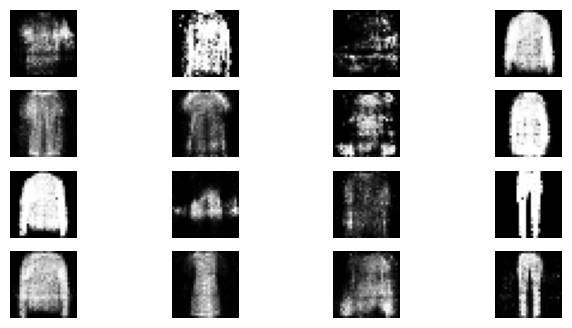

 82%|████████▏ | 41/50 [02:04<00:26,  2.91s/it]

Time for epoch 41 is 2.627885341644287 sec
Training started with  epoch 42 with 469 batches...
Losses after epoch    42: generator 2.226, discriminator 0.571, real_score 76.86%, fake_score 18.64%


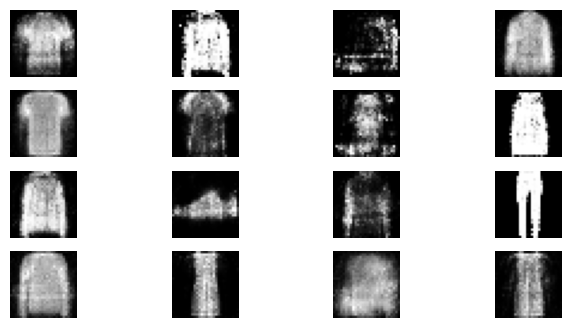

 84%|████████▍ | 42/50 [02:07<00:24,  3.00s/it]

Time for epoch 42 is 3.2196009159088135 sec
Training started with  epoch 43 with 469 batches...
Losses after epoch    43: generator 1.993, discriminator 1.126, real_score 71.39%, fake_score 27.96%


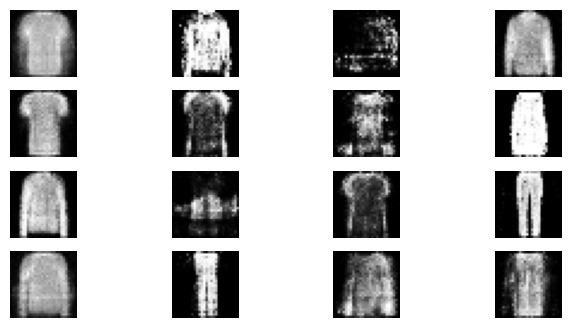

 86%|████████▌ | 43/50 [02:10<00:20,  2.96s/it]

Time for epoch 43 is 2.853264808654785 sec
Training started with  epoch 44 with 469 batches...
Losses after epoch    44: generator 2.194, discriminator 0.668, real_score 78.69%, fake_score 22.39%


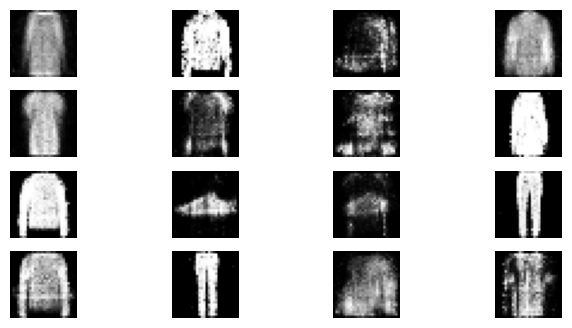

 88%|████████▊ | 44/50 [02:13<00:17,  2.95s/it]

Time for epoch 44 is 2.929858446121216 sec
Training started with  epoch 45 with 469 batches...
Losses after epoch    45: generator 1.980, discriminator 0.648, real_score 76.89%, fake_score 19.20%


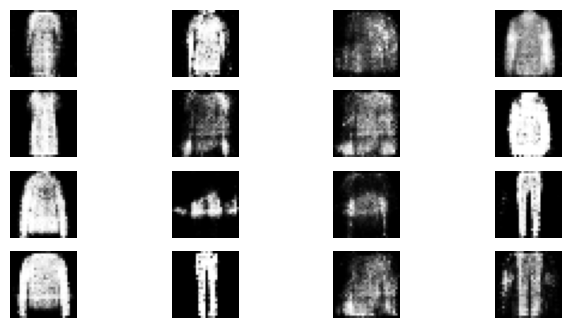

 90%|█████████ | 45/50 [02:16<00:14,  2.88s/it]

Time for epoch 45 is 2.7234230041503906 sec
Training started with  epoch 46 with 469 batches...
Losses after epoch    46: generator 2.733, discriminator 0.521, real_score 76.26%, fake_score 12.37%


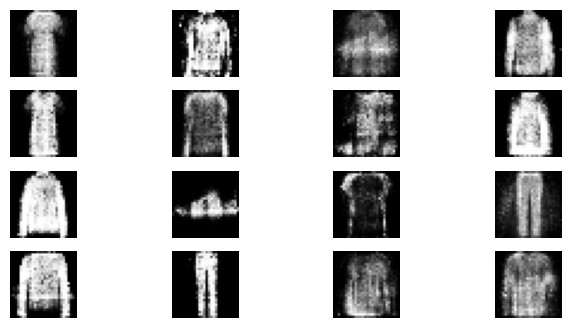

 92%|█████████▏| 46/50 [02:19<00:11,  2.87s/it]

Time for epoch 46 is 2.833015203475952 sec
Training started with  epoch 47 with 469 batches...
Losses after epoch    47: generator 1.393, discriminator 1.077, real_score 76.63%, fake_score 36.03%


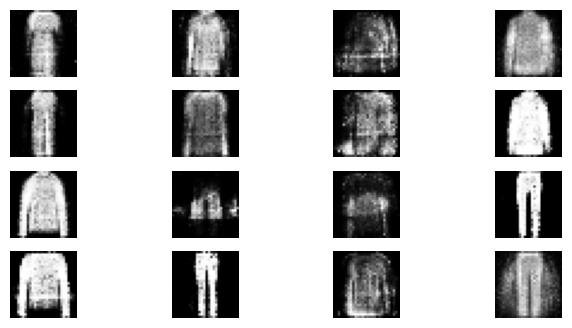

 94%|█████████▍| 47/50 [02:22<00:08,  2.98s/it]

Time for epoch 47 is 3.2268478870391846 sec
Training started with  epoch 48 with 469 batches...
Losses after epoch    48: generator 2.134, discriminator 0.722, real_score 79.19%, fake_score 23.59%


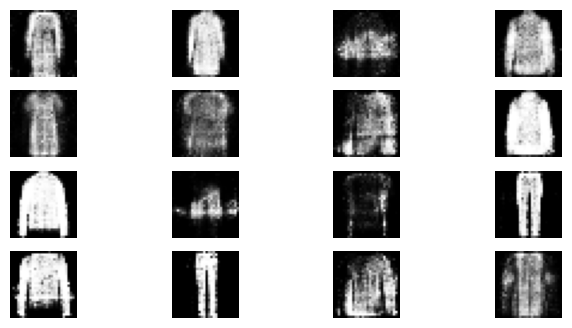

 96%|█████████▌| 48/50 [02:25<00:05,  2.93s/it]

Time for epoch 48 is 2.8062047958374023 sec
Training started with  epoch 49 with 469 batches...
Losses after epoch    49: generator 2.028, discriminator 0.674, real_score 72.37%, fake_score 21.67%


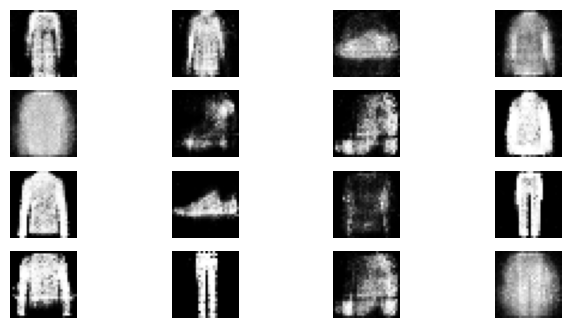

 98%|█████████▊| 49/50 [02:28<00:02,  2.96s/it]

Time for epoch 49 is 3.0161545276641846 sec
Training started with  epoch 50 with 469 batches...
Losses after epoch    50: generator 1.188, discriminator 1.501, real_score 60.34%, fake_score 39.10%


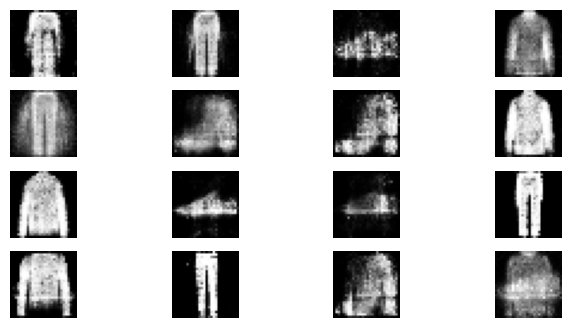

100%|██████████| 50/50 [02:31<00:00,  3.02s/it]

Time for epoch 50 is 2.815582752227783 sec


In [35]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

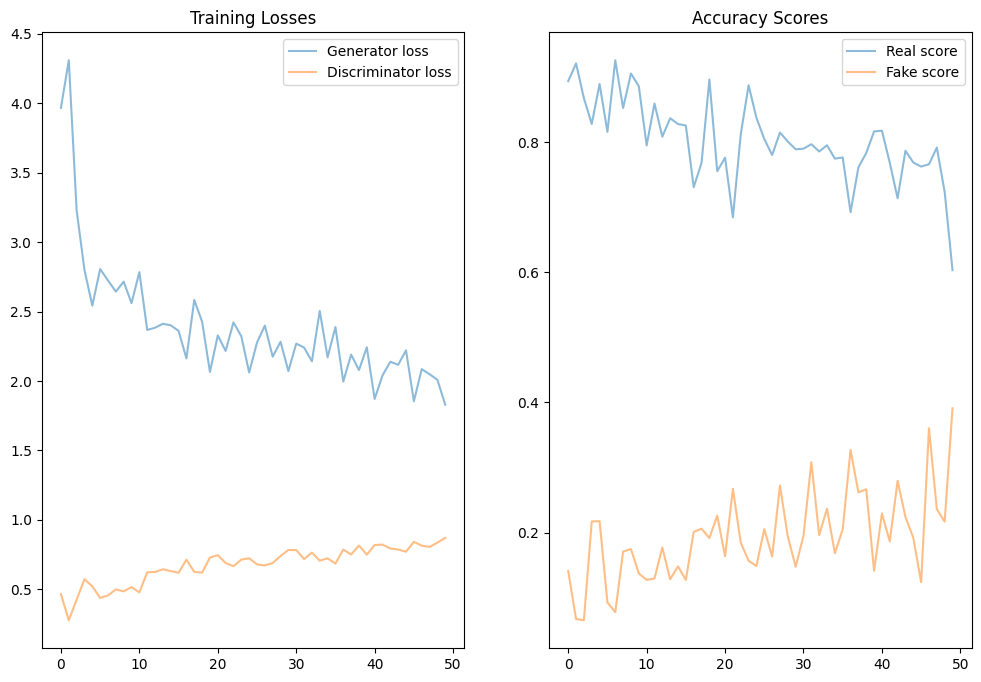

In [36]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()